In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sys

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from energy_datasets.spain_energy_weather import sp_energy_loader as sp


In [2]:
class MainConfig:
    context_length = 12
    lags_sequence = [1, 2, 3, 4, 5, 6, 7]
    prediction_length = 14
    wandb = False
    train_batch_size = 8
    valid_batch_size = 16
    lr = 5e-3
    epochs = 20#50
    device = "cuda" if torch.cuda.is_available() else "cpu" # Sometimes there's an issue with trying to use gpu



In [4]:
"""Extracting data"""
df = sp.get_raw_dataframe()
df = sp.proc_dataframe_dates(df)
df[:30]


,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,year,week,hour
0,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41,0.995553,0.019231,0
1,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92,0.995553,0.019231,1
2,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48,0.995553,0.019231,2
3,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32,0.995553,0.019231,3
4,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04,0.995553,0.019231,4
5,410.0,178.0,4038.0,3590.0,156.0,2109.0,952.0,743.0,7098.0,43.0,...,4618.0,4.0,4617.0,21441.0,19905.0,35.72,53.63,0.995553,0.019231,5
6,401.0,172.0,4040.0,3368.0,158.0,2108.0,961.0,848.0,7098.0,43.0,...,4397.0,3.0,4276.0,21285.0,20010.0,35.13,51.73,0.995553,0.019231,6
7,408.0,172.0,4030.0,3208.0,160.0,2031.0,983.0,1012.0,7099.0,43.0,...,3992.0,12.0,3994.0,21545.0,20377.0,36.22,51.43,0.995553,0.019231,7
8,413.0,177.0,4052.0,3335.0,161.0,2119.0,1001.0,1015.0,7098.0,43.0,...,3629.0,39.0,3602.0,21443.0,20094.0,32.40,48.98,0.995553,0.019231,8
9,419.0,177.0,4137.0,3437.0,163.0,2170.0,1041.0,1357.0,7097.0,43.0,...,3073.0,784.0,3212.0,21560.0,20637.0,36.60,54.20,0.995553,0.019231,9


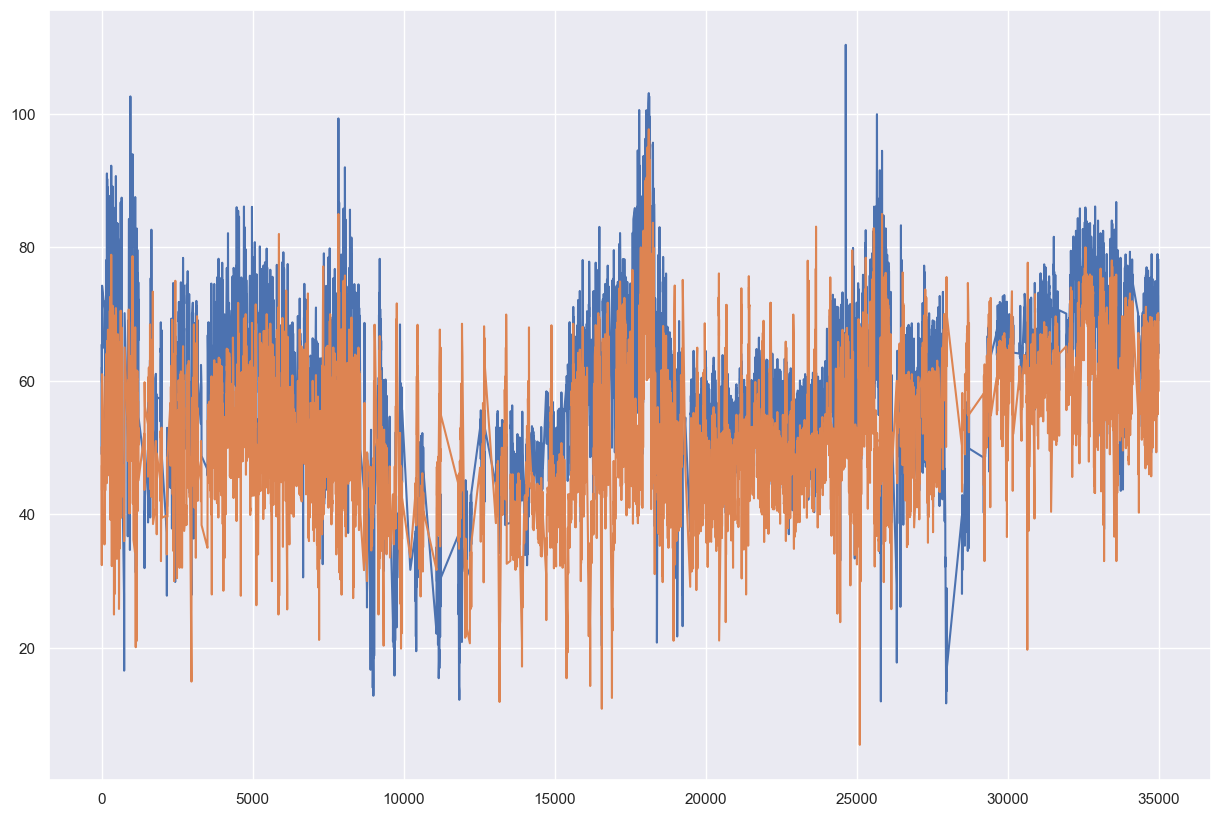

In [5]:
"""Check data"""
sns.set_theme()
plt.figure(figsize= (15, 10))
plt.plot(df['price actual'])
plt.plot(df['price day ahead'])
plt.show()

In [6]:
scale = MinMaxScaler(feature_range=(-1, 1)) # The normalizer
df_scaled = df.copy()

for c in df_scaled.columns:
    df_scaled[c] = scale.fit_transform(df_scaled[c].values.reshape(-1, 1))



df_scaled

In [7]:
scale.fit(df['price actual'].values.reshape(-1, 1))

MinMaxScaler(feature_range=(-1, 1))

In [8]:
def get_rolling_window(df:pd.DataFrame, context_length=None, predict_length=None, win_size=None, format='list'):#, return_dict=False):
    """Window Splitting"""
    if win_size is None:
        win_size = context_length + predict_length
    rolling_bins = df.rolling(window=(win_size), closed='left')

    if format=='dataframe':
        return [s for s in rolling_bins][win_size:]

    if format=='dict':
        return [s.to_dict(orient='list') for s in (rolling_bins)][win_size:]
    
    rolling_bins = [list(s.values) for s in (rolling_bins)][win_size:]

    return rolling_bins

In [9]:
train_size = int(0.8*len(df.index))
test_size = df.index-train_size

testing_df = df.iloc[:200]

dict_train = {
    "past_values":[], 
    "future_values":[], 
    "past_time_features":[], 
    "future_time_features":[], 
    'past_observed_mask':[]
}

dict_test = {
    "past_values":[], 
    "future_values":[], 
    "past_time_features":[], 
    "future_time_features":[],
    'past_observed_mask':[]
}

win_size=MainConfig.context_length + max(MainConfig.lags_sequence) + MainConfig.prediction_length
train_seg = MainConfig.context_length + max(MainConfig.lags_sequence)
pred_seg = MainConfig.prediction_length

df_rolling = get_rolling_window(df_scaled, win_size=win_size, format='dataframe')#return_dict=True)


for datapt in df_rolling[:train_size]:
    dict_train['past_values'].append(datapt['price actual'].iloc[:train_seg].values)
    dict_train['future_values'].append(datapt['price actual'].iloc[train_seg:train_seg+pred_seg].values)
    dict_train['future_time_features'].append(datapt.drop(['price actual'], axis=1).iloc[train_seg:train_seg+pred_seg].values)
    dict_train['past_observed_mask'].append([1]*(train_seg))
    dict_train['past_time_features'].append(datapt.drop(['price actual'], axis=1).iloc[:train_seg].values)

for datapt in df_rolling[train_size:]:
    dict_test['past_values'].append(datapt['price actual'].iloc[:train_seg].values)
    dict_test['future_values'].append(datapt['price actual'].iloc[train_seg:train_seg+pred_seg].values)
    dict_test['future_time_features'].append(datapt.drop(['price actual'], axis=1).iloc[train_seg:train_seg+pred_seg].values)
    dict_test['past_time_features'].append(datapt.drop(['price actual'], axis=1).iloc[:train_seg].values)
    dict_test['past_observed_mask'].append([1]*(train_seg))

In [10]:
"""
"past_values", 
"future_values",
"past_time_features",
"future_time_features"
"""
"""Dataset (dictionary)"""
from torch.utils.data import Dataset
class EnergyDataset(Dataset):
    def __init__(self, df:pd.DataFrame):
        self.len = len(df.index)
        self.dict_values = df.to_dict(orient='list')
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        return {
            k : torch.tensor(v[idx]).float().to('cpu') for k, v in self.dict_values.items() 
        }


In [11]:
eds_train = EnergyDataset(df=pd.DataFrame(dict_train))
eds_train[0]

{'past_values': tensor([ 0.0701, -0.0345, -0.1010, -0.1498, -0.1883, -0.1944, -0.2441, -0.1383,
         -0.0422, -0.0235, -0.0182,  0.0209,  0.0211, -0.0255,  0.0032,  0.0754,
          0.2684,  0.2680,  0.1976]),
 'future_values': tensor([ 0.0785,  0.2120,  0.0758, -0.0162, -0.0787, -0.1435, -0.1539, -0.0880,
          0.0501,  0.1030,  0.2226,  0.0639,  0.0223,  0.0221]),
 'past_time_features': tensor([[ 0.3094, -0.3534, -0.6523,  0.0142, -0.7273, -0.4738, -0.1400, -0.7327,
           0.9890, -0.2353, -0.2105, -0.9828, -0.3036, -0.3181, -0.9975, -0.3163,
          -0.5213, -0.5869, -0.0924, -1.0000, -1.0000, -0.8261],
         [ 0.2614, -0.4920, -0.7382, -0.1063, -0.7091, -0.3204, -0.1700, -0.8606,
           0.9884, -0.2353, -0.1579, -0.9828, -0.3441, -0.3472, -0.9996, -0.3561,
          -0.6027, -0.7182, -0.2021, -1.0000, -1.0000, -0.7391],
         [ 0.2134, -0.6265, -0.7673, -0.1843, -0.7333, -0.1742, -0.1650, -0.8734,
           0.9878, -0.2353, -0.1842, -0.9857, -0.3603, -0.38

In [12]:
"""model 2"""
from transformers import AutoformerConfig, AutoformerModel, AutoformerForPrediction, get_cosine_schedule_with_warmup

config = AutoformerConfig(
                          prediction_length=MainConfig.prediction_length, 
                          context_length=MainConfig.context_length,
                          lags_sequence=MainConfig.lags_sequence,
                          num_time_features=len(dict_test['future_time_features'][0][0]),                              
                          d_model=16,
                          encoder_layers=1,
                          decoder_layers=1,
                          encoder_ffn_dim=8,
                          decoder_ffn_dim=8,
                          distribution_output="student_t",
                          moving_average=15,
                          num_parallel_samples=1000,
                          dropout=0,
                          encoder_layerdrop=0,
                          decoder_layerdrop=0,
                          activation_dropout=0,
                          #return_dict=True
)
model = AutoformerForPrediction(config).to(MainConfig.device) # The model


In [13]:
config.num_time_features

22

In [1]:
from torch.optim import AdamW
from transformers import (
    get_cosine_schedule_with_warmup, 
    TrainingArguments,
    Trainer
)

"""Set up training params"""
optimizer = AdamW(model.parameters(), lr=MainConfig.lr)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=200, num_training_steps=int(len(eds_train)/MainConfig.train_batch_size)*MainConfig.epochs)

def model_init():
    return model


arguments = TrainingArguments(output_dir="tmp_trainer", 
                      learning_rate=MainConfig.lr, 
                      per_device_train_batch_size=MainConfig.train_batch_size, 
                      per_device_eval_batch_size=MainConfig.valid_batch_size, 
                      save_strategy="epoch",
                      num_train_epochs=MainConfig.epochs,
                      ignore_data_skip=True,
                      warmup_ratio=0.8,
                      label_smoothing_factor=0.0,
                      logging_strategy="epoch",
                      use_cpu=True,
                      )

trainer = Trainer(model=model,
         train_dataset=eds_train, 
         args=arguments,
         optimizers=(optimizer, scheduler)
         )

NameError: name 'model' is not defined

In [24]:
trainer.train()

  0%|          | 0/28020 [00:00<?, ?it/s]

In [ ]:

model.eval()


AutoformerForPrediction(
  (model): AutoformerModel(
    (scaler): AutoformerMeanScaler()
    (encoder): AutoformerEncoder(
      (value_embedding): AutoformerValueEmbedding(
        (value_projection): Linear(in_features=31, out_features=16, bias=False)
      )
      (embed_positions): AutoformerSinusoidalPositionalEmbedding(26, 16)
      (layers): ModuleList(
        (0): AutoformerEncoderLayer(
          (self_attn): AutoformerAttention(
            (k_proj): Linear(in_features=16, out_features=16, bias=True)
            (v_proj): Linear(in_features=16, out_features=16, bias=True)
            (q_proj): Linear(in_features=16, out_features=16, bias=True)
            (out_proj): Linear(in_features=16, out_features=16, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=16, out_features=8, bias=True)
          (fc2): Linear(in_features=8, out_features

In [ ]:
sample = dict_test
test_amount = 100
sample = {
            k : torch.tensor(v)[:test_amount].float().to('cpu') for k, v in dict_test.items() 
        }

sample['future_time_features'].shape

/var/folders/2t/dh69lmc920l_h8vbm87mpzcw0000gn/T/ipykernel_788/506263559.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  k : torch.tensor(v)[:test_amount].float().to('cpu') for k, v in dict_test.items()


torch.Size([100, 14, 22])

In [ ]:
"""Loading"""
# model = AutoformerForPrediction.from_pretrained(r'saved_models/SOTA_scaled')
# model.eval()

AutoformerForPrediction(
  (model): AutoformerModel(
    (scaler): AutoformerMeanScaler()
    (encoder): AutoformerEncoder(
      (value_embedding): AutoformerValueEmbedding(
        (value_projection): Linear(in_features=31, out_features=16, bias=False)
      )
      (embed_positions): AutoformerSinusoidalPositionalEmbedding(26, 16)
      (layers): ModuleList(
        (0): AutoformerEncoderLayer(
          (self_attn): AutoformerAttention(
            (k_proj): Linear(in_features=16, out_features=16, bias=True)
            (v_proj): Linear(in_features=16, out_features=16, bias=True)
            (q_proj): Linear(in_features=16, out_features=16, bias=True)
            (out_proj): Linear(in_features=16, out_features=16, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=16, out_features=8, bias=True)
          (fc2): Linear(in_features=8, out_features

In [ ]:
# pd.DataFrame(sample['past_time_features']).rolling(window=4).mean()
sample['past_time_features'].shape, sample['past_values'].shape
# sample['past_values']
# dict_test
# past_samp = testing_df[]
# dict_train['future_values']
sample['future_time_features'] = []

win_size=7
for past_time_feature in sample['past_time_features'][-7:]:
     sample['future_time_features'].append(pd.DataFrame(past_time_feature).rolling(window=7,closed='both', min_periods=1).mean().values)

for i in range(win_size, test_amount):
     sample['future_time_features'].append(pd.DataFrame(sample['future_time_features'][i-win_size]).rolling(window=7,closed='both', min_periods=1).mean().values)

i=0
# for past_time_feature in sample['past_time_features']:
#     i+=1
#     sample['future_time_features'].append(pd.DataFrame(past_time_feature).rolling(window=7,closed='both', min_periods=1).mean().values)
#     # sample['future_time_features'][:7] = [0]*19#list(past_time_feature[:-7])

# for i in range(len(sample['past_time_features'])):
#     if i < 7:
#         sample['future_time_features']
sample['future_time_features'] = torch.tensor(sample['future_time_features'], dtype=torch.float32)

In [ ]:
sample['past_time_features'].shape, i
sample['future_time_features']#.shape#.dtype
# test_amount-win_size

# torch.tensor(sample['future_time_features'][0].values).shape


tensor([[[-0.0791, -0.6225, -0.7617,  ...,  1.0000, -0.7308, -0.9130],
         [-0.0959, -0.6245, -0.7709,  ...,  1.0000, -0.7308, -0.8696],
         [-0.1047, -0.6185, -0.7791,  ...,  1.0000, -0.7308, -0.8261],
         ...,
         [ 0.0851, -0.1230, -0.6404,  ...,  1.0000, -0.7308, -0.0652],
         [ 0.0815, -0.1473, -0.6498,  ...,  1.0000, -0.7308, -0.1739],
         [ 0.0689, -0.1345, -0.6602,  ...,  1.0000, -0.7308, -0.2826]],

        [[-0.1127, -0.6265, -0.7801,  ...,  1.0000, -0.7308, -0.8261],
         [-0.1175, -0.6165, -0.7878,  ...,  1.0000, -0.7308, -0.7826],
         [-0.1175, -0.6191, -0.7854,  ...,  1.0000, -0.7308, -0.7391],
         ...,
         [ 0.0815, -0.1473, -0.6498,  ...,  1.0000, -0.7308, -0.1739],
         [ 0.0689, -0.1345, -0.6602,  ...,  1.0000, -0.7308, -0.2826],
         [ 0.0701, -0.0756, -0.6218,  ...,  1.0000, -0.7308, -0.3152]],

        [[-0.1223, -0.6064, -0.7956,  ...,  1.0000, -0.7308, -0.7391],
         [-0.1199, -0.6155, -0.7881,  ...,  1

In [ ]:
outputs = model.generate(
    past_values = sample["past_values"],
    past_time_features = sample["past_time_features"],
    past_observed_mask = sample["past_observed_mask"],
    future_time_features = sample["future_time_features"],
)

In [ ]:
y_pred = (outputs.sequences.mean(dim=1))
y_acc = sample['future_values']
y_pred.shape, y_acc, y_pred

(torch.Size([100, 14]),
 tensor([[-0.2062, -0.2299, -0.2495,  ..., -0.1928, -0.1654, -0.0866],
         [-0.2299, -0.2495, -0.2131,  ..., -0.1654, -0.0866, -0.0099],
         [-0.2495, -0.2131, -0.1739,  ..., -0.0866, -0.0099, -0.0722],
         ...,
         [-0.0381, -0.0637, -0.0685,  ..., -0.0280, -0.0472, -0.0825],
         [-0.0637, -0.0685, -0.0438,  ..., -0.0472, -0.0825, -0.1078],
         [-0.0685, -0.0438,  0.0111,  ..., -0.0825, -0.1078, -0.0324]]),
 tensor([[-0.2109, -0.1825, -0.1545,  ..., -0.0673, -0.0913, -0.1575],
         [-0.1625, -0.1441, -0.1252,  ..., -0.0926, -0.1066, -0.1439],
         [-0.1422, -0.1259, -0.1268,  ..., -0.1223, -0.1020, -0.1489],
         ...,
         [ 0.0532,  0.0261,  0.0050,  ...,  0.0265,  0.0425,  0.0007],
         [-0.0987, -0.1166, -0.1123,  ..., -0.1513, -0.1385, -0.1707],
         [-0.0802, -0.0874, -0.0882,  ..., -0.1438, -0.1370, -0.1760]]))

In [ ]:
# scale = MinMaxScaler(feature_range=(-1, 1))

predict = pd.DataFrame(scale.inverse_transform(y_pred.cpu().detach().numpy()))
original = pd.DataFrame(scale.inverse_transform(y_acc))
sota = df['price day ahead'].iloc[train_size:train_size+test_amount]

# predict = pd.DataFrame(y_pred.cpu().detach().numpy())
# original = pd.DataFrame(y_acc)
# f = predict
# f.columns = f.columns.to_series()


In [ ]:
# scale.inverse_transform(y_pred.cpu().detach().numpy())


In [ ]:
# See predicted vs original values
print(predict)
print(original)
# print(y_acc)

# Flatten predictions into predict_len chunks
pred_flattened = torch.tensor([])
for i in range(0, len(predict.index), MainConfig.prediction_length):
    pred_flattened = torch.cat((pred_flattened, torch.tensor(predict.iloc[i])))

predict_flattened = pd.DataFrame(pred_flattened)[:len(predict.index)]

          0         1         2         3         4         5         6   \
0  -0.210880 -0.182550 -0.154538 -0.113923 -0.069571 -0.037559 -0.018629   
1  -0.162493 -0.144055 -0.125157 -0.105141 -0.078429 -0.033697 -0.005754   
2  -0.142192 -0.125871 -0.126843 -0.109621 -0.080230 -0.027782  0.001919   
3  -0.110777 -0.105942 -0.113004 -0.090525 -0.038710  0.003425 -0.020694   
4  -0.107206 -0.092837 -0.103230 -0.053184 -0.010027 -0.035399 -0.058092   
..       ...       ...       ...       ...       ...       ...       ...   
95 -0.258445 -0.238338 -0.221832 -0.227595 -0.198844 -0.191594 -0.202988   
96 -0.136242 -0.145809 -0.150158 -0.134455 -0.104749 -0.094727 -0.115171   
97  0.053217  0.026060  0.004999  0.004639  0.031440  0.054980  0.035052   
98 -0.098702 -0.116612 -0.112293 -0.109501 -0.111843 -0.119055 -0.138358   
99 -0.080182 -0.087432 -0.088235 -0.098142 -0.116722 -0.128014 -0.134516   

          7         8         9         10        11        12        13  
0  -0.006849

[Text(-20.0, 0, ''),
 Text(0.0, 0, ''),
 Text(20.0, 0, ''),
 Text(40.0, 0, ''),
 Text(60.0, 0, ''),
 Text(80.0, 0, ''),
 Text(100.0, 0, ''),
 Text(120.0, 0, '')]

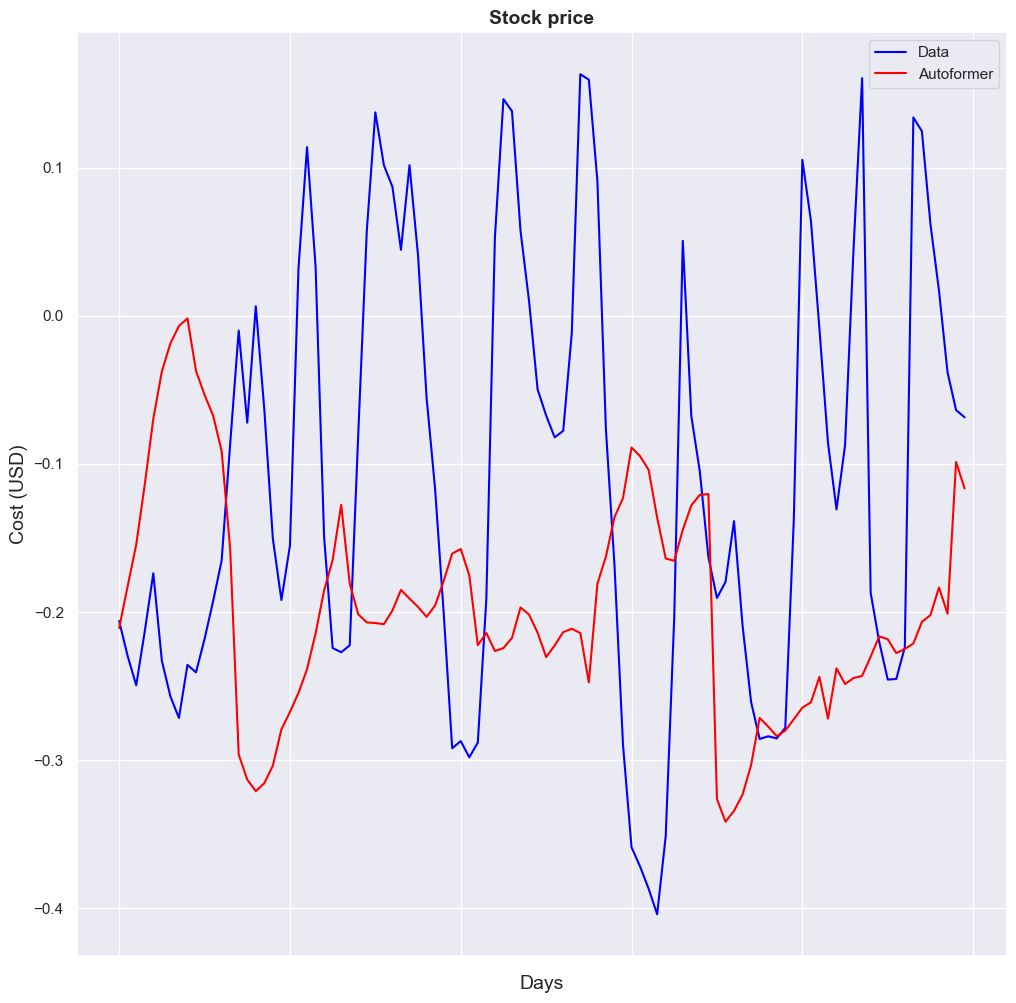

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict_flattened.values.squeeze(), label="Autoformer", color='red')
# ax = sns.lineplot(x = predict.index, y = sota, label="Sota", color='green')

ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


In [ ]:
# model.save_pretrained("/Users/ishanshastri/Desktop/nus/CPMF/autoformer/saved_models/t2")
model_loaded = AutoformerForPrediction.from_pretrained(r'/Users/ishanshastri/Desktop/nus/CPMF/autoformer/saved_models/t3_good_10-day')